Tutorial: Own structures and materials
=================
This tutorial demonstrates how user-defined structure models and material classes can be implemented in pyGDM.

*Note:* Structures can also be loaded from text-files as a list of (x,y,z) coordinates. Material dispersions can also be loaded from files containing tabulated data via the "materials.fromFile" class.

First load pyGDM
-------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import core
from pyGDM2 import fields
from pyGDM2 import structures
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

Implement a structure generator
--------------------------------------

For this example we implement a simple structure generator, which will return the coordinates of a volume discretized cube. The important part is the definition of "condition_cube", which will be called to choose whether a meshpoint coordinate lies inside or outside the volume of the structure.

In [2]:
from pyGDM2.structures import _meshCubic, _meshHexagonalCompact

def structure_cube(step, L, mesh='cube', orientation_hex=1):
    """Generate volume discretized cube. Side length 'L', stepsize 'step'"""
    
    ## condition for a point being inside the cube volume
    def condition_cube(xi,yi,zi):
        return (0<xi<=L and 0<yi<=L and 0<zi<=L)
    
    ## call mesher
    if mesh == 'cube':
        sp = _meshCubic( (-2, int(L)+2), (-2, int(L)+2), (0, int(L)+1), 
                        condition_cube)
    elif mesh == 'hex':
        sp = _meshHexagonalCompact( (-2, int(L)+2), (-2, int(L)+2), (-2, int(L)+2), 
                                    condition_cube, orientation_hex)
    
    ## convert to numpy array and scale with discretization stepsize
    sp = np.array(sp, dtype=np.float)
    sp *= step
    
    return sp

Let's test the new structure model.

/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/visu.py:48: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


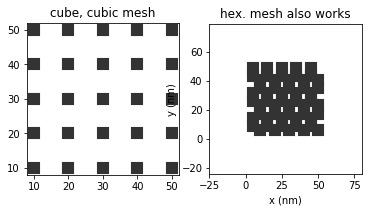

In [3]:
step = 10.0
geometry = structure_cube(step, L=5, mesh='cube')
geometry_hex = structure_cube(step, L=5, mesh='hex')


plt.subplot(121, aspect='equal')
pt = visu.structure(geometry, tit='cube, cubic mesh', show=0)
plt.subplot(122, aspect='equal')
pt = visu.structure(geometry_hex, tit='hex. mesh also works', show=1)

Implement a material dispersion class
--------------------------------------

To demonstrate the material class, we implement a simple material with constant refractive index of $n=2$. 

*Note* that the complex permittivity ($\epsilon$) is expected by pyGDM.

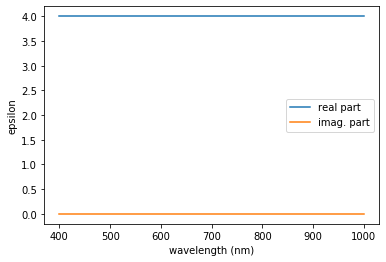

In [4]:
class refindex_n2(object):
    def __init__(self):
        self.__name__ = 'constant index, n=2'
    
    def epsilon(self, wavelength):
        """return the index n=2 (epsilon=4)"""
        eps = complex(4.0)
        return eps


## test the dispersion
material_n2 = refindex_n2()
la = np.linspace(400, 1000, 50)


plt.plot(la, [material_n2.epsilon(l).real for l in la], label='real part')
plt.plot(la, [material_n2.epsilon(l).imag for l in la], label='imag. part')

plt.xlabel("wavelength (nm)")
plt.ylabel("epsilon")
plt.legend()
plt.show()

Test the own model in a simulation
-----------------------------

Now let's test the own model and dispersion in a simple simulation

timing for wl=400.00nm - setup: 10.6 ms, inv.: 97.6 ms, repropa.: 0.7ms (1 field configs), tot: 109.4 ms


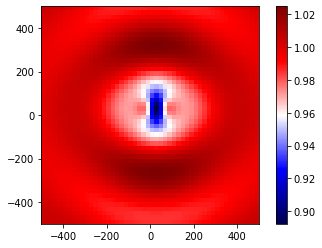

In [5]:
## setup structure and disperision 
n1, n2 = 1.0, 1.0
struct = structures.struct(step, geometry, material_n2, n1,n2, 
                           structures.get_normalization('cube'))

field_generator = fields.planewave
efield = fields.efield(field_generator, wavelengths=[400], 
                       kwargs=dict(theta = [0.0]))

sim = core.simulation(struct, efield)

## run the scattering simulation
EF = core.scatter(sim)

## plot the near-field in a plane close to the cube
r_probe = tools.generate_NF_map(-500,500,50, -500,500,50, Z0=100)
nearfield = linear.nearfield(sim, field_index=0, r_probe=r_probe)[1]

im = visu.vectorfield_color(nearfield, show=0)
plt.colorbar(im)
plt.show()